In [488]:
%config InlineBackend.figure_format = 'svg'
import os, sys

sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from abm1559.utils import constants

from abm1559.txpool import TxPool

from abm1559.users import User1559

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)
from abm1559.simulator import (
    spawn_poisson_demand,
    update_basefee,
)

import pandas as pd
from pomegranate import *
import numpy as np
import json
import matplotlib.pyplot as plt

In [52]:
UserClass = User1559
demand_scenario = [2000 for i in range(200)]

# Instantiate a couple of things
txpool = TxPool()
basefee = constants["INITIAL_BASEFEE"]
chain = Chain()
metrics = []
user_pool = UserPool()

for t in range(len(demand_scenario)):

    # `env` is the "environment" of the simulation
    env = {
            "basefee": basefee,
            "current_block": t,
    }

    # We return a demand drawn from a Poisson distribution.
    # The parameter is given by `demand_scenario[t]`, and can vary
    # over time.
    users = spawn_poisson_demand(t, demand_scenario[t], UserClass)

    # We query each new user with the current basefee value
    # Users either return a transaction or None if they prefer to balk
    decided_txs = user_pool.decide_transactions(users, env)

    # New transactions are added to the transaction pool
    txpool.add_txs(decided_txs)

    # The best valid transactions are taken out of the pool for inclusion
    selected_txs = txpool.select_transactions(env)
    txpool.remove_txs([tx.tx_hash for tx in selected_txs])

    # We create a block with these transactions
    block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

    # The block is added to the chain
    chain.add_block(block)
    
    # A couple of metrics we will use to monitor the simulation
    row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "gas_used": sum([tx.gas_used for tx in block.txs]),
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length,
    }
    metrics.append(row_metrics)

    # Finally, basefee is updated and a new round starts
    basefee = update_basefee(block, basefee)
    
    if (t % 10 == 0): print('{:.1f}%'.format(100*((t)/len(demand_scenario))), end='\r')
        
df = pd.DataFrame(metrics)        

In [441]:
def simulate_gas_demand(t, demand_scenario):
    users = spawn_poisson_demand(t, demand_scenario[t], UserClass)
    txs = []
    for user in users:
        tx = user.transact(env)
        if not tx is None:
            txs.append(tx)

    return 21000*len(txs)  

In [486]:
N = 1000
gas_demand = np.zeros(N)
demand_scenario = [2000 for i in range(N)]
for t in range(N):
    gas_demand[t] = simulate_gas_demand(t,demand_scenario)
    if (t % 10 == 0): print('{:.1f}%'.format(100*((t)/len(demand_scenario))), end='\r')

In [490]:
chain_df = chain.export()

In [510]:
chain_df

,block_height,tx_index,basefee,tx,start_block,sender,gas_used,tx_hash,gas_premium,max_fee,tip
0,0,0,1.000000,1559 Transaction 1e66b5ab3cdae4ce: max_fee 177...,0,5a15915cc137142f,21000,1e66b5ab3cdae4ce,1.0,17.767642,1.0
1,0,1,1.000000,1559 Transaction b9af310f998c0144: max_fee 106...,0,10f28a4d1228613b,21000,b9af310f998c0144,1.0,10.689746,1.0
2,0,2,1.000000,1559 Transaction 16347158eb0db248: max_fee 698...,0,f6c1a223753f193b,21000,16347158eb0db248,1.0,6.981581,1.0
3,0,3,1.000000,1559 Transaction f05a6a5edcc4613d: max_fee 568...,0,734148105ca154b5,21000,f05a6a5edcc4613d,1.0,5.687656,1.0
4,0,4,1.000000,1559 Transaction a5b9ca5c0491f4e1: max_fee 167...,0,efcba6ef958a3568,21000,a5b9ca5c0491f4e1,1.0,16.750914,1.0
...,...,...,...,...,...,...,...,...,...,...,...
131052,199,598,10.631044,1559 Transaction 2296975f0d502339: max_fee 149...,199,47ac4834acfb6194,21000,2296975f0d502339,1.0,14.983336,1.0
131053,199,599,10.631044,1559 Transaction 83e734416f4240b6: max_fee 189...,199,7df5ea7b82a9319a,21000,83e734416f4240b6,1.0,18.901730,1.0
131054,199,600,10.631044,1559 Transaction 338712639e882ea2: max_fee 197...,199,084041a96d02f2a3,21000,338712639e882ea2,1.0,19.753162,1.0
131055,199,601,10.631044,1559 Transaction 1f723ff0336b82d7: max_fee 177...,199,800df614c53f4f29,21000,1f723ff0336b82d7,1.0,17.730384,1.0


In [507]:
chain_df.loc[chain_df['block_height'] == 100,['gas_used']].sum()

gas_used    11592000
dtype: int64

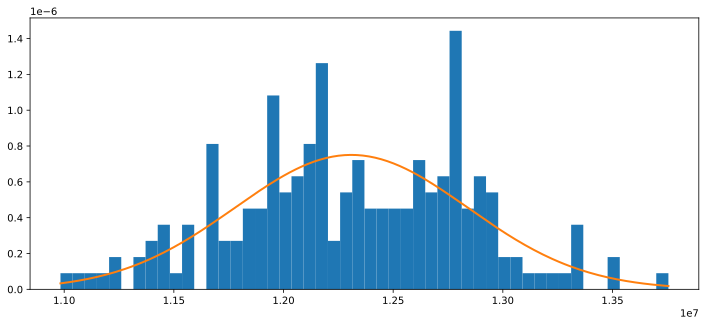

In [453]:
sim = gas_demand
basefees_sim = sim.flatten()
values = np.linspace(min(basefees_sim), max(basefees_sim), len(basefees_sim))
sample = basefees_sim.reshape(-1,1)
normal_model = NormalDistribution.from_samples(sample)
normal_fit = normal_model.probability(values.flatten())

fig = plt.figure(figsize=(12, 5))
plt.hist(sample, bins=50, density=True)
plt.plot(values, normal_fit, label="Gamma fit", linewidth=2)

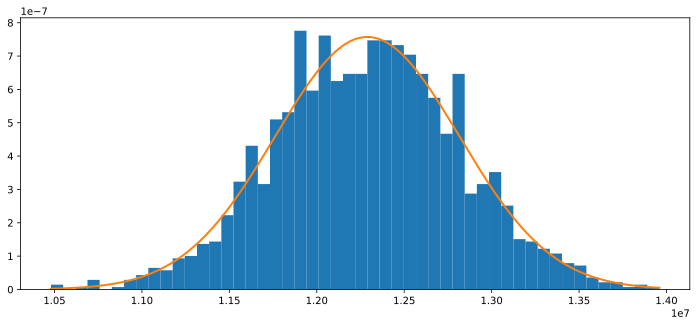

In [489]:
model_params = json.loads(normal_model.to_json())['parameters']

sim = np.random.normal(model_params[0], model_params[1], 2000)
basefees_sim = sim.flatten()
values = np.linspace(min(basefees_sim), max(basefees_sim), len(basefees_sim))
sample = basefees_sim.reshape(-1,1)
normal_model = NormalDistribution.from_samples(sample)
normal_fit = normal_model.probability(values.flatten())

fig = plt.figure(figsize=(12, 5))
plt.hist(sample, bins=50, density=True)
plt.plot(values, normal_fit, label="Gamma fit", linewidth=2)

In [116]:
df

,block,basefee,users,decided_txs,included_txs,gas_used,blk_avg_gas_price,blk_avg_tip,pool_length
0,0,1.000000,2060,1573,1190,24990000,2.000000,1.0,<bound method TxPool.pool_length of <abm1559.t...
1,1,1.124900,1986,1506,1190,24990000,2.124900,1.0,<bound method TxPool.pool_length of <abm1559.t...
2,2,1.265400,2006,1528,1190,24990000,2.265400,1.0,<bound method TxPool.pool_length of <abm1559.t...
3,3,1.423448,2035,1551,1190,24990000,2.423448,1.0,<bound method TxPool.pool_length of <abm1559.t...
4,4,1.601237,1987,1499,1190,24990000,2.601237,1.0,<bound method TxPool.pool_length of <abm1559.t...
...,...,...,...,...,...,...,...,...,...
195,195,10.656125,2000,600,600,12600000,11.656125,1.0,<bound method TxPool.pool_length of <abm1559.t...
196,196,10.666781,1964,583,583,12243000,11.666781,1.0,<bound method TxPool.pool_length of <abm1559.t...
197,197,10.639368,2041,559,559,11739000,11.639368,1.0,<bound method TxPool.pool_length of <abm1559.t...
198,198,10.558402,2005,628,628,13188000,11.558402,1.0,<bound method TxPool.pool_length of <abm1559.t...


<AxesSubplot:xlabel='block'>

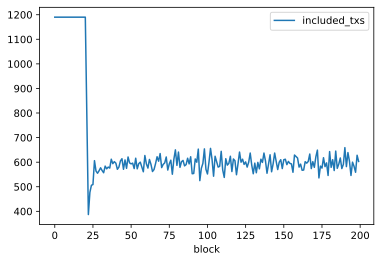

In [346]:
df.plot("block", ["included_txs"])

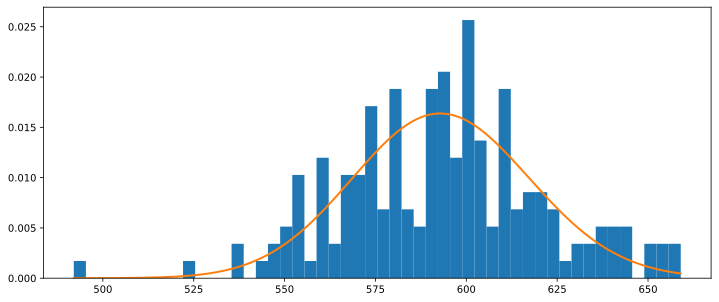

In [67]:
sim = df['decided_txs'].values[25:]
basefees_sim = sim.flatten()
values = np.linspace(min(basefees_sim), max(basefees_sim), len(basefees_sim))
sample = basefees_sim.reshape(-1,1)
normal_model = PoissonDistribution.from_samples(sample)
normal_fit = normal_model.probability(values.flatten())

fig = plt.figure(figsize=(12, 5))
plt.hist(sample, bins=50, density=True)
plt.plot(values, normal_fit, label="Gamma fit", linewidth=2)

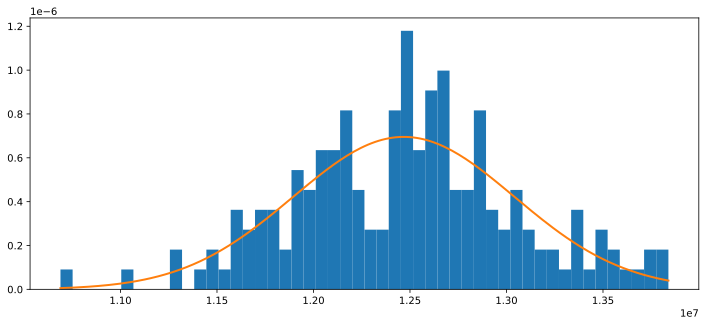

In [149]:
sim = df['gas_used'].values[25:]
basefees_sim = sim.flatten()
values = np.linspace(min(basefees_sim), max(basefees_sim), len(basefees_sim))
sample = basefees_sim.reshape(-1,1)
normal_model = NormalDistribution.from_samples(sample)
normal_fit = normal_model.probability(values.flatten())

fig = plt.figure(figsize=(12, 5))
plt.hist(sample, bins=50, density=True)
plt.plot(values, normal_fit, label="Gamma fit", linewidth=2)

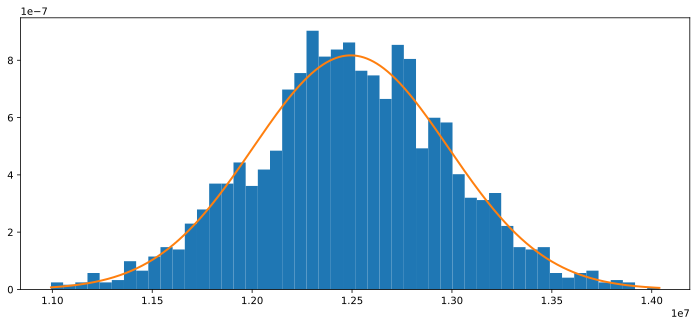

In [148]:
sim = np.random.normal(12500000, 500000, 2000)
basefees_sim = sim.flatten()
values = np.linspace(min(basefees_sim), max(basefees_sim), len(basefees_sim))
sample = basefees_sim.reshape(-1,1)
normal_model = NormalDistribution.from_samples(sample)
normal_fit = normal_model.probability(values.flatten())

fig = plt.figure(figsize=(12, 5))
plt.hist(sample, bins=50, density=True)
plt.plot(values, normal_fit, label="Gamma fit", linewidth=2)

<AxesSubplot:xlabel='block'>

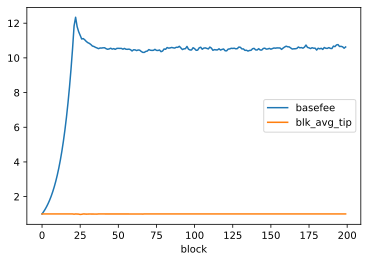

In [62]:
df.plot("block", ["basefee", "blk_avg_tip"])